<a href="https://colab.research.google.com/github/veruizr/micropython/blob/main/Grua_abierta_red_neuronal_para_micropython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar librerías
pandas, numpy, escaladores,y redeses neuronales con Pytorch

In [1]:
# Procesamiento de datos
import pandas as pd
import numpy as np

# Preprocesamiento y partición de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch (red neuronal)
import torch
import torch.nn as nn
import torch.optim as optim


###Cargar el dataset y adecuarlo para usarlo en el entrenamiento de la red neuronal

In [2]:
# Cargar el archivo CSV generado (ajusta la ruta según corresponda)
df = pd.read_csv('dataset_grua_cinematica.csv')

# Visualizar las primeras filas para comprobar la estructura
print(df.head())

# Seleccionar las columnas de entrada (X) y salida (y)
# Entradas: posiciones x, y
X = df[['x', 'y']].values

# Salidas: ángulos theta1, theta2, theta3
y = df[['theta1', 'theta2', 'theta3']].values


          x         y    theta1    theta2    theta3
0  7.287561 -0.929594  0.349066 -0.523599 -1.570796
1  7.519354 -0.943095  0.349066 -0.523599 -1.338086
2  7.748012 -0.902776  0.349066 -0.523599 -1.105375
3  7.961209 -0.810812  0.349066 -0.523599 -0.872665
4  8.147450 -0.672160  0.349066 -0.523599 -0.639954


## Definición de escaladores
Se normalizan los datos para ser procesados y se dejan listos los escaladores, para ser utilizados posteriormente en micropython

In [3]:
# Normalizar entradas y salidas usando StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Exportar parámetros de los escaladores (media y desviación estándar) para uso en MicroPython
import json
scaler_params = {
    "X_mean": scaler_X.mean_.tolist(),
    "X_scale": scaler_X.scale_.tolist(),
    "y_mean": scaler_y.mean_.tolist(),
    "y_scale": scaler_y.scale_.tolist()
}
with open("scaler_params.json", "w") as f:
    json.dump(scaler_params, f)

# División en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Conversión a tensores de PyTorch
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


##Definición de la red neuronal usando Pytorch

In [4]:
import torch.nn as nn

class Grua(nn.Module):
    def __init__(self):
        super(Grua, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),   # Capa oculta 1: 64 neuronas
            nn.ReLU(),
            nn.Linear(64, 64),  # Capa oculta 2: 64 neuronas
            nn.ReLU(),
            nn.Linear(64, 3)    # Salida: 3 neuronas (ángulos)
        )

    def forward(self, x):
        return self.layers(x)

model = Grua()


## Entrenamiento de la red neuronal


Epoch 0 | Train Loss: 1.038229 | Val Loss: 1.021807
Epoch 50 | Train Loss: 0.603189 | Val Loss: 0.648696
Epoch 100 | Train Loss: 0.488266 | Val Loss: 0.534143
Epoch 150 | Train Loss: 0.443504 | Val Loss: 0.506539
Epoch 200 | Train Loss: 0.423008 | Val Loss: 0.480930
Epoch 250 | Train Loss: 0.410027 | Val Loss: 0.463334
Epoch 300 | Train Loss: 0.404311 | Val Loss: 0.456045
Epoch 350 | Train Loss: 0.401526 | Val Loss: 0.455687
Epoch 400 | Train Loss: 0.399739 | Val Loss: 0.456259
Epoch 450 | Train Loss: 0.398305 | Val Loss: 0.457410


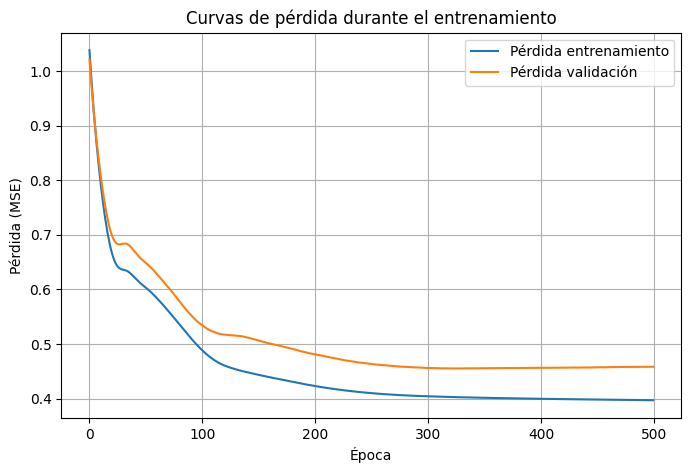


Test Loss final: 0.458370


In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Listas para almacenar el historial de pérdida
train_losses = []
val_losses = []

epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluar en el conjunto de prueba/validación
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test)
        val_loss = criterion(val_pred, y_test)
        val_losses.append(val_loss.item())

    if epoch % 50 == 0:
        print(f'Epoch {epoch} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}')

# Graficar las pérdidas
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Pérdida entrenamiento')
plt.plot(val_losses, label='Pérdida validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.title('Curvas de pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

# Evaluación final en el conjunto de prueba
print(f"\nTest Loss final: {val_losses[-1]:.6f}")

# Guardar el modelo entrenado en formato PyTorch por si quieres seguir experimentando en PC
torch.save(model.state_dict(), 'Grua.pth')


## Exportación de pesos y sesgos en formato para lectura en micropython

In [6]:
import json

# Acceder a los parámetros del modelo
state_dict = model.state_dict()

# Extraer y convertir a listas los pesos y sesgos de cada capa
weights_biases = {
    "layer1_weight": state_dict['layers.0.weight'].cpu().numpy().tolist(),  # Input -> Capa oculta 1
    "layer1_bias":   state_dict['layers.0.bias'].cpu().numpy().tolist(),
    "layer2_weight": state_dict['layers.2.weight'].cpu().numpy().tolist(),  # Oculta 1 -> Oculta 2
    "layer2_bias":   state_dict['layers.2.bias'].cpu().numpy().tolist(),
    "layer3_weight": state_dict['layers.4.weight'].cpu().numpy().tolist(),  # Oculta 2 -> Salida
    "layer3_bias":   state_dict['layers.4.bias'].cpu().numpy().tolist(),
}

# Guardar como archivo JSON listo para usar en MicroPython
with open('grua_weights.json', 'w') as f:
    json.dump(weights_biases, f)


##Implementación en micropython para microcontroladores

In [9]:
import json # se utiliza para revisión usando python
# se utiliza la libreria ujson para cargar los archivos en micropython

# import ujson

import math

class NNPredictor:
    def __init__(self, weights_path, scaler_path):
        # Cargar pesos y sesgos
        with open(weights_path, 'r') as f:
           # self.weights = ujson.load(f)
            self.weights = json.load(f)
        # Cargar parámetros de escalado
        with open(scaler_path, 'r') as f:
            #self.scalers = ujson.load(f)
            self.scalers = json.load(f)
    def escalar_entrada(self, x, y):
        mean = self.scalers['X_mean']
        scale = self.scalers['X_scale']
        return [(x - mean[0]) / scale[0], (y - mean[1]) / scale[1]]

    def desescalar_salida(self, thetas):
        mean = self.scalers['y_mean']
        scale = self.scalers['y_scale']
        return [thetas[i] * scale[i] + mean[i] for i in range(3)]

    def relu(self, vec):
        return [max(0, v) for v in vec]

    def matvec(self, mat, vec):
        return [
            sum(mat[i][j] * vec[j] for j in range(len(vec)))
            for i in range(len(mat))
        ]

    def predict(self, x, y):
        # Paso 1: Escalar entrada
        inp = self.escalar_entrada(x, y)

        # Paso 2: Forward pass (propagación hacia adelante)
        # Capa 1
        out1 = self.matvec(self.weights['layer1_weight'], inp)
        out1 = [out1[i] + self.weights['layer1_bias'][i] for i in range(64)]
        out1 = self.relu(out1)

        # Capa 2
        out2 = self.matvec(self.weights['layer2_weight'], out1)
        out2 = [out2[i] + self.weights['layer2_bias'][i] for i in range(64)]
        out2 = self.relu(out2)

        # Capa de salida
        out3 = self.matvec(self.weights['layer3_weight'], out2)
        out3 = [out3[i] + self.weights['layer3_bias'][i] for i in range(3)]

        # Paso 3: Desescalar la salida
        thetas = self.desescalar_salida(out3)
        return thetas  # [theta1, theta2, theta3] en radianes

    def predict_batch(self, trayectoria):
        """
        trayectoria: lista de tuplas [(x, y), ...]
        retorna: lista de listas [[theta1, theta2, theta3], ...]
        """
        return [self.predict(x, y) for (x, y) in trayectoria]

# --- USO DE EJEMPLO ---
# Instanciar la clase y predecir para una trayectoria completa
nn = NNPredictor('grua_weights.json', 'scaler_params.json')
trayectoria = [(4.0, 5.0), (5.0, 6.0), (6.0, 7.0)]
angulos = nn.predict_batch(trayectoria)

for i, (punto, ang) in enumerate(zip(trayectoria, angulos)):
    print(f"Punto {i}: {punto} -> Ángulos (radianes): {ang}")
    print(f"Punto {i}: {punto} -> Ángulos (grados): {[math.degrees(a) for a in ang]}")



Punto 0: (4.0, 5.0) -> Ángulos (radianes): [0.6562971530766373, 0.6238409624606824, -2.2790721575527]
Punto 0: (4.0, 5.0) -> Ángulos (grados): [37.603056977742646, 35.74345423637633, -130.58121583354432]
Punto 1: (5.0, 6.0) -> Ángulos (radianes): [0.6842417499464997, 0.4472614683040345, -1.2432525468059334]
Punto 1: (5.0, 6.0) -> Ángulos (grados): [39.20416443858025, 25.62619447264542, -71.23312380087083]
Punto 2: (6.0, 7.0) -> Ángulos (radianes): [0.9934709591730149, -0.24253552173398424, 0.852969739697434]
Punto 2: (6.0, 7.0) -> Ángulos (grados): [56.92169302942747, -13.896261777360747, 48.871566137035394]
